# How to:
## Visuzlize Jackknifed Measurement Sets
Here, we just quickly show the results. We have build-in some tools for visualization if you want to use them. But, all the outputs are fits files and measurement sets, so you simply use your own scripts on the outputs.

In [1]:
import jacked

Just getting the same initialization as the previous setup

In [2]:
#initilaize
tool = jacked.Jack(fname   = '../data/Glass-z13.ms', # The file name of the visibilities, 
                   outdir  = '../output/', #the directory to save the outputs in
                   fields  = ['3'], # Each visibility can have multiple fields, 
                   spws    = [['0']], # and each field can have multiple spws,
                   band    = 'Band7', # Band of the observation,
                   array   = 'C7', # which configuration the observation are taken in,
                   )

Or if you want multiple simulatiously, just run:

## Image data

`tool.run(fname)` from the previous notebooks runs the entire pipeline. However, we can just call submodules to image the data seperately. So let's image the original data set the same way as we do for the Jackknifed, to get a feel for the data

In [3]:
# tool.clean( '../data/Glass-z13.ms', reffreq = '254.35GHz')
tool.outfile = '../output/cubes/Glass-z13.im'

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


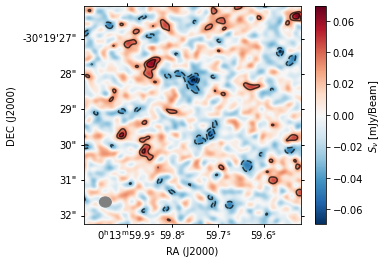

In [4]:
tool.plot_map(savedir = '../plots/', moment = 'continuum')

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


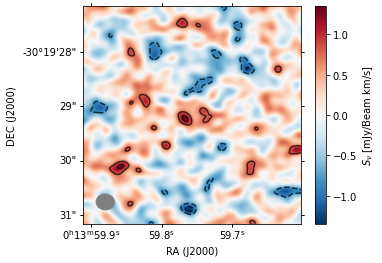

In [5]:
tool.plot_map(savedir = '../plots/', moment = 'moment-0', channels = [13,23], box_size_arcsec=4, center_coord=(3.498985, -30.324767))

## SLP

In [ ]:
freqs = np.arange(len(self.cube))*self.header['CDELT3'] + self.header['CRVAL3']
velos = (freqs-254.35e9)/254.35e9*const.c.to(u.km/u.s).value
index = np.argmin(np.abs(velos))

In [ ]:
class SLP():
    """
    A class that manages cleaned data cubes and estiamtes the spectral line profile of that cube given a mask to sum over
    Input:
        cube (channel, image, image): Cleaned data in units of Jy/pixel
        mask (image, image): A mask that matches the size of the image. The mask is used to some over the pixels.
    Output (with function execute):
        slp (len(channels)): Intensity, units of Jy.
        bootstrap_std: bootstrapped std in units of Jy. 
    
    """
    
    def __init__(self, cube, mask, amount = 200, visualize = False):
        self.visualize = visualize
        self.cube   = cube
        self.mask   = mask
        self.amount = amount
        
        xx, yy         = np.meshgrid(np.arange(0,self.cube.shape[-2], 1), np.arange(0, self.cube.shape[-1],1))
        self.CoM_mask  =  (np.mean(xx[self.mask]), np.mean(yy[self.mask]))
        self.rr        = ((xx-self.CoM_mask[0])**2 + (yy-self.CoM_mask[1])**2)**0.5
        
        self.mask_size = int(np.sum(self.mask)**0.5+0.1*self.cube.shape[-2]) # --> quick fix

    def _position(self):

        r =  np.sqrt(np.random.uniform(0.1,1, size = self.amount))
        theta = np.random.uniform(0,1, size = self.amount) * 2 * np.pi

        x = self.CoM_mask[0] + self.cube.shape[1]/3 *r* np.cos(theta) #hard coded
        y = self.CoM_mask[1] + self.cube.shape[1]/3 *r* np.sin(theta) #hard coded
        
        pos = np.array([x,y], dtype = np.int).T
        return np.vstack(([int(self.CoM_mask[0]), int(self.CoM_mask[1])], pos))

    def _make_mask(self, pos):
        new_masks = np.zeros((len(pos[1:]),self.im.shape[-2], self.im.shape[-1]))
        for idx, xy in enumerate(pos[1:]):
            new_masks[idx, 
                      xy[0]-self.mask_size//2:xy[0]+self.mask_size//2, 
                      xy[1]-self.mask_size//2:xy[1]+self.mask_size//2] = self.mask[pos[0][0]-self.mask_size//2:pos[0][0]+self.mask_size//2, 
                                                                                   pos[0][1]-self.mask_size//2:pos[0][1]+self.mask_size//2]
            
            
        return new_masks.astype(bool)  
    
    def _estimates(self, new_masks):
        estimates = []
        for m in new_masks:
            estimates.append(np.sum(self.im[m]))
        return np.nanstd(estimates), np.nanmean(estimates)
    
    def _visualize(self, masks):
        for idx, m in enumerate(masks):
            clear_output(True)
            plt.imshow(m, origin='lower')
            plt.show()
            if idx>30: break
    
    def execute(self):

        bootstrap_std = []
        bootstrap_means = []
        for i in tqdm(range(len(self.cube))):
            self.im = self.cube[i]
            pos     = self._position()
            masks   = self._make_mask(pos)            

            std, mean = self._estimates(masks)
            bootstrap_std.append(std)
            bootstrap_means.append(mean)
            
        if self.visualize: self._visualize(masks)

        return np.array(bootstrap_std), np.array(bootstrap_means)

In [ ]:
def circle_mask(im, xc, yc, rcirc):
        ny, nx = im.shape
        y,x = np.mgrid[0:nx,0:ny]
        r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
        return ( (r < rcirc))

def ellipsoid_mask(im, xc, yc, a, b, Theta):
    ny, nx = im.shape
    y,x = np.mgrid[0:nx,0:ny]
    e = (((x-xc) * np.cos(Theta) + (y - yc)*np.sin(Theta))**2)/a**2 +  (((x-xc) * np.sin(Theta) - (y - yc)*np.cos(Theta))**2)/b**2
    return (e<=1)

In [ ]:
# fname = '../output/cleaned/Glass-z13_target_concat_tbin30s_cwidth38MHz_60spwline.im.fits'

# # Load in Cube
# # ------------
# cube, header = fits.getdata(fname, header = True)

# BMAJ = np.average(hdu[1].data['BMAJ'])/3600  # degrees
# BMIN = np.average(hdu[1].data['BMIN'])/3600  # degrees
# BPA = np.average(hdu[1].data['BPA'])  # Position angle in degrees

# pixel_size = header['CDELT1']
# Dfreq    = header['CDELT3']
# restfreq = header['CRVAL3']

# BeamArea     = np.pi *BMIN*BMAJ/pixel_size**2/(4*np.log(2))   # pixels per beam 
# cube         = cube[0]/BeamArea*1e3                           # mJy/pixel

# mask = ellipsoid_mask(cube[0], 
#                       len(cube[0])//2, 
#                       len(cube[0])//2, 
#                       BMIN/pixel_size, 
#                       BMAJ/pixel_size, 
#                       np.deg2rad(BPA))


# xaxis      = (np.arange(len(cube))*Dfreq + restfreq)/1e9    
# slp        = np.nansum(cube[:, mask], axis = 1)
# normal_std = np.nanstd(cube[:,~mask], axis = 1) * np.sqrt(np.sum(mask))
# mask = ellipsoid_mask(cube[0], 
#                       len(cube[0])//2, 
#                       len(cube[0])//2, 
#                       BMIN/pixel_size, 
#                       BMAJ/pixel_size, 
#                       np.deg2rad(BPA))

# obj                           = SLP(cube, mask, amount = 1000, visualize=False)
# bootstrap_std, bootstrap_mean = obj.execute()

# # Visualize SLP
# # -----------------
# fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [2, 1]})

# ax[0].step(xaxis, slp/bootstrap_std, label = 'Central Beam', c = 'C0')
# ax[0].axhline(0, c='gray', ls='--')
# ax[0].set_xlim(xmin = xaxis[0], xmax = xaxis[-1])
# ax[0].set_ylim(ymin =-2.5, ymax = 3.5)
# ax[0].set_ylabel('SNR')
# ax[0].legend(loc = 1, frameon=False)
# ax[0].axvline(254.35, c = 'k')

# # ax[1].step(xaxis, normal_std, label='conventional image')
# ax[1].step(xaxis, bootstrap_std, label='bootstrap', c = 'C1')
# ax[1].axhline(np.nanstd(slp), label='std spectral', c='k', alpha = 0.6)    

# ax[1].set_xlim(xmin = xaxis[0], xmax = xaxis[-1])
# ax[1].set_ylim(ymin = 0.15, ymax = 0.25)
# ax[1].set_xlabel('Freq [GHz]')
# ax[1].set_ylabel('mJy')
# ax[1].legend(loc = 1, frameon=False)

# plt.tight_layout()
# plt.show()

In [ ]:
# fname = '../output/cleaned/Glass-z13_target_concat_tbin30s_cwidth38MHz_60spw_contsubline.im.fits'

# # Load in Cube
# # ------------
# cube, header = fits.getdata(fname, header = True)

# BMAJ = np.average(hdu[1].data['BMAJ'])/3600  # degrees
# BMIN = np.average(hdu[1].data['BMIN'])/3600  # degrees
# BPA = np.average(hdu[1].data['BPA'])  # Position angle in degrees

# pixel_size = header['CDELT1']
# Dfreq    = header['CDELT3']
# restfreq = header['CRVAL3']

# BeamArea     = np.pi *BMIN*BMAJ/pixel_size**2/(4*np.log(2))   # pixels per beam 
# cube         = cube[0]/BeamArea*1e3                           # mJy/pixel

# mask = ellipsoid_mask(cube[0], 
#                       len(cube[0])//2, 
#                       len(cube[0])//2, 
#                       BMIN/pixel_size, 
#                       BMAJ/pixel_size, 
#                       np.deg2rad(BPA))


# xaxis      = (np.arange(len(cube))*Dfreq + restfreq)/1e9    
# slp        = np.nansum(cube[:, mask], axis = 1)
# normal_std = np.nanstd(cube[:,~mask], axis = 1) * np.sqrt(np.sum(mask))
# mask = ellipsoid_mask(cube[0], 
#                       len(cube[0])//2, 
#                       len(cube[0])//2, 
#                       BMIN/pixel_size, 
#                       BMAJ/pixel_size, 
#                       np.deg2rad(BPA))

# obj                           = SLP(cube, mask, amount = 1000, visualize=False)
# bootstrap_std, bootstrap_mean = obj.execute()

# # Visualize SLP
# # -----------------
# fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [2, 1]})

# ax[0].step(xaxis, slp/bootstrap_std, label = 'Central Beam', c = 'C0')
# ax[0].axhline(0, c='gray', ls='--')
# ax[0].set_xlim(xmin = xaxis[0], xmax = xaxis[-1])
# ax[0].set_ylim(ymin =-2.5, ymax = 3.5)
# ax[0].set_ylabel('SNR')
# ax[0].legend(loc = 1, frameon=False)
# ax[0].axvline(254.35, c = 'k')

# # ax[1].step(xaxis, normal_std, label='conventional image')
# ax[1].step(xaxis, bootstrap_std, label='bootstrap', c = 'C1')
# ax[1].axhline(np.nanstd(slp), label='std spectral', c='k', alpha = 0.6)    

# ax[1].set_xlim(xmin = xaxis[0], xmax = xaxis[-1])
# ax[1].set_ylim(ymin = 0.15, ymax = 0.25)
# ax[1].set_xlabel('Freq [GHz]')
# ax[1].set_ylabel('mJy')
# ax[1].legend(loc = 1, frameon=False)

# plt.tight_layout()
# plt.show()

# Jacked version

In [ ]:
plot_fits_image_with_wcs(fits_file, 4, (3.498985, -30.324767),  (index-5, index+5))  # Replace with your FITS file path, desired box size in arcseconds, and center coordinates (RA, DEC)
direc = './output/C7/model/'
fits_files = os.listdir(direc)

In [ ]:
for f in fits_files:
    if f.endswith('.fits'):
        plot_fits_image_with_wcs(direc+f, 4, (3.498985, -30.324767),  (index-5, index+5))  # Replace with your FITS file path, desired box size in arcseconds, and center coordinates (RA, DEC)

# Line Finder